In [7]:
import librosa
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [3]:
metadata = pd.read_csv("fma_small_extracted/fma_metadata/tracks.csv", index_col=0, header=[0, 1])
print(metadata.head())


            album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                      

In [1]:
import os
import librosa
from tqdm import tqdm
import pandas as pd
import numpy as np

# Define paths
AUDIO_PATH = "fma_small_extracted/fma_small/"
LOG_FILE = "skipped_files_log.txt"

# Define fixed feature sizes
MFCC_SIZE = 13
CHROMA_SIZE = 12
MEL_SIZE = 40
SPEC_CONTRAST_SIZE = 7

def pad_or_truncate(feature, length):
    """Ensure a feature vector has the required fixed length."""
    if len(feature) > length:
        return feature[:length]  # Truncate
    return feature + [0] * (length - len(feature))  # Pad with zeros

def extract_features(file_path):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=44100, mono=True, duration=25, res_type="kaiser_fast")

        # Skip empty or silent files
        if len(y) == 0 or np.mean(np.abs(y)) < 1e-10:
            with open(LOG_FILE, "a") as log:
                log.write(f"Skipping {file_path}: Empty or very low energy audio\n")
            return None

        features = []

        try:
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=MFCC_SIZE).mean(axis=1).tolist()
            features.extend(pad_or_truncate(mfccs, MFCC_SIZE))
        except:
            return None

        try:
            chroma = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1).tolist()
            features.extend(pad_or_truncate(chroma, CHROMA_SIZE))
        except:
            return None

        try:
            mel = librosa.feature.melspectrogram(y=y, sr=sr).mean(axis=1).tolist()
            features.extend(pad_or_truncate(mel, MEL_SIZE))
        except:
            return None

        try:
            spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1).tolist()
            features.extend(pad_or_truncate(spec_contrast, SPEC_CONTRAST_SIZE))
        except:
            return None

        try:
            features.append(librosa.feature.spectral_centroid(y=y, sr=sr).mean())
        except:
            return None

        try:
            features.append(librosa.feature.spectral_bandwidth(y=y, sr=sr).mean())
        except:
            return None

        try:
            features.append(librosa.feature.spectral_rolloff(y=y, sr=sr).mean())
        except:
            return None

        try:
            features.append(librosa.feature.zero_crossing_rate(y).mean())
        except:
            return None

        try:
            features.append(librosa.feature.rms(y=y).mean())
        except:
            return None

        try:
            tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
            features.append(tempo.item() if tempo.size > 0 else 0.0)
        except:
            features.append(0.0)

        return features

    except Exception as e:
        with open(LOG_FILE, "a") as log:
            log.write(f"Error processing {file_path}: {e}\n")
        return None

# ---- RUN FEATURE EXTRACTION ---- #
features_list, filenames = [], []
skipped_files = 0

# Get all MP3 files in dataset
all_files = []
for root, _, files in os.walk(AUDIO_PATH):
    for file in files:
        if file.endswith(".mp3"):
            all_files.append(os.path.join(root, file))

print(f"Found {len(all_files)} audio files.")

# Process all files
for file_path in tqdm(all_files):
    feature_vector = extract_features(file_path)
    if feature_vector is not None:
        features_list.append(feature_vector)
        filenames.append(os.path.basename(file_path))
    else:
        skipped_files += 1

# Save features to CSV instead of NumPy array
df = pd.DataFrame(features_list)
df["filename"] = filenames
df.to_csv("features.csv", index=False)

print(f"Feature extraction complete! Extracted {len(features_list)} samples.")
print(f"Skipped {skipped_files} files due to errors or inconsistencies.")


Found 8000 audio files.


 55%|█████▌    | 4423/8000 [5:44:20<49:42,  1.20it/s]       C:\Users\jayes\AppData\Local\Temp\ipykernel_26196\683525659.py:26: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=44100, mono=True, duration=25, res_type="kaiser_fast")
d:\M.LEARNING\.venv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 8000/8000 [6:35:50<00:00,  2.97s/it]


Feature extraction complete! Extracted 7996 samples.
Skipped 4 files due to errors or inconsistencies.


In [2]:
df = pd.read_csv("features.csv")


MFCC_SIZE = 13
CHROMA_SIZE = 12
MEL_SIZE = 40
SPEC_CONTRAST_SIZE = 7

feature_columns = (
    [f"mfcc_{i+1}" for i in range(MFCC_SIZE)] +  
    [f"chroma_{i+1}" for i in range(CHROMA_SIZE)] +  
    [f"mel_{i+1}" for i in range(MEL_SIZE)] +  
    [f"spec_contrast_{i+1}" for i in range(SPEC_CONTRAST_SIZE)] +  
    ["spectral_centroid", "spectral_bandwidth", "spectral_rolloff",  
     "zero_crossing_rate", "rms_energy", "tempo", "filename"]
)

# Rename columns
df.columns = feature_columns

# Save the fixed CSV
df.to_csv("features_fixed.csv", index=False)

print("✅ Column names updated! Saved as 'features_fixed.csv'.")


✅ Column names updated! Saved as 'features_fixed.csv'.


In [8]:
df = pd.read_csv("features_fixed.csv")
print(df.head())
print(df.columns)

       mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -120.754501  118.818161 -42.580620  38.166370 -23.106148  23.685431   
1 -161.653656  131.976288 -17.913349  51.571606 -16.201942  22.950804   
2  -77.011719  156.819458 -65.480850  23.388184   2.322881  10.541369   
3 -339.035583  133.516571  22.282366  54.495518  12.679288  38.229401   
4 -276.684143  156.459702   0.303282  22.480015  10.651305  13.976653   

      mfcc_7     mfcc_8    mfcc_9    mfcc_10  ...  spec_contrast_5  \
0 -12.221414  13.505067 -7.219168   4.128035  ...        17.062219   
1  -8.510356  10.583506 -0.321892  13.101320  ...        16.665419   
2 -13.031978   9.965072 -7.314209   3.242464  ...        16.579513   
3   0.068375  14.505986  7.048670  -1.787688  ...        16.666273   
4 -12.150264  10.255483  0.439787  -7.983494  ...        17.921774   

   spec_contrast_6  spec_contrast_7  spectral_centroid  spectral_bandwidth  \
0        17.381144        56.673935        3648.096361        

In [9]:

print(df.isnull().sum())
print(df.describe())


mfcc_1                0
mfcc_2                0
mfcc_3                0
mfcc_4                0
mfcc_5                0
                     ..
spectral_rolloff      0
zero_crossing_rate    0
rms_energy            0
tempo                 0
filename              0
Length: 79, dtype: int64
            mfcc_1       mfcc_2       mfcc_3       mfcc_4       mfcc_5  \
count  7996.000000  7996.000000  7996.000000  7996.000000  7996.000000   
mean   -186.363750   153.979495   -15.293567    33.401899     0.354123   
std     100.408059    36.752058    32.327046    19.358804    15.328548   
min    -996.500610   -39.502800  -151.761139   -72.374931   -78.789825   
25%    -244.554203   129.378941   -36.377832    23.459766    -9.597266   
50%    -173.928429   153.524292   -16.605314    35.670654    -0.223759   
75%    -115.442110   177.324947     3.681427    45.685675     9.666359   
max     154.483749   279.439484   144.444656   120.566673    66.481544   

            mfcc_6       mfcc_7       mfcc_8

In [27]:

from sklearn.preprocessing import StandardScaler

df = pd.read_csv("features_fixed.csv")
df.drop(columns=['filename'], inplace=True)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df)

features = np.array(features_scaled)
print(f"Features Shape: {features.shape}")


Features Shape: (7996, 78)


In [11]:
SEQ_LENGTH = 10  # Number of time steps per sample

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Create sequences
sequences = create_sequences(features, SEQ_LENGTH)
print(f"Sequential Features Shape: {sequences.shape}")  # Expected: (num_samples, timesteps, num_features)


Sequential Features Shape: (7986, 10, 78)


In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(sequences, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_data = tf.convert_to_tensor(train_data, dtype=tf.float32)
val_data = tf.convert_to_tensor(val_data, dtype=tf.float32)

# Print shapes
print(f"Train Shape: {train_data.shape}, Validation Shape: {val_data.shape}")


Train Shape: (6388, 10, 78), Validation Shape: (1598, 10, 78)


In [18]:
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf

# Register the sampling function
@tf.keras.utils.register_keras_serializable()
def sampling(args):
    """Reparameterization trick for VAE."""
    z_mean, z_log_var = args
    batch_size = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, LATENT_DIM), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Model parameters
LATENT_DIM = 16  # Latent space size
FEATURE_DIM = features.shape[1]  # Number of input features
TIME_STEPS = SEQ_LENGTH  # Time steps per sequence
L2_REG = 1e-4  # L2 regularization strength
DROPOUT_RATE = 0.2  # Dropout rate

# ---- ENCODER ---- #
encoder_inputs = Input(shape=(TIME_STEPS, FEATURE_DIM), name="encoder_input")
x = LSTM(64, return_sequences=True, kernel_regularizer=l2(L2_REG))(encoder_inputs)
x = Dropout(DROPOUT_RATE)(x)
x = LSTM(32, return_sequences=False, kernel_regularizer=l2(L2_REG))(x)

# Latent space
z_mean = Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = Dense(LATENT_DIM, name="z_log_var")(x)

# Apply sampling
z = Lambda(sampling, output_shape=(LATENT_DIM,), name="z")([z_mean, z_log_var])

# ---- DECODER ---- #
decoder_inputs = RepeatVector(TIME_STEPS)(z)
x = LSTM(32, return_sequences=True, kernel_regularizer=l2(L2_REG))(decoder_inputs)
x = Dropout(DROPOUT_RATE)(x)
x = LSTM(64, return_sequences=True, kernel_regularizer=l2(L2_REG))(x)
decoder_outputs = TimeDistributed(Dense(FEATURE_DIM, activation="sigmoid"), name="decoder_output")(x)

# ---- FULL VAE MODEL ---- #
vae = Model(encoder_inputs, decoder_outputs, name="VAE")

# ---- LOSS FUNCTION (Custom Layer) ---- #
@tf.keras.utils.register_keras_serializable()
class VAELossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        y_true, y_pred, z_mean, z_log_var = inputs
        
        # Reconstruction loss (Mean Squared Error)
        reconstruction_loss = K.mean(K.square(y_true - y_pred))
        
        # KL Divergence loss
        kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)) * 0.1  # Increased effect
        
        # Total loss
        self.add_loss(reconstruction_loss + kl_loss)
        return y_pred

# Add the custom loss layer
outputs = VAELossLayer()([encoder_inputs, decoder_outputs, z_mean, z_log_var])
vae = Model(encoder_inputs, outputs)

# Optimizer
adamw_optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)

# Compile the model
vae.compile(optimizer=adamw_optimizer)
vae.summary()

# ---- SAVE THE MODEL ---- #
vae.save("my_model.keras")  # Use .keras format
print("✅ Model saved successfully!")



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 10, 78)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 10, 64)    │     36,608 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 64)    │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │     12,416 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        528 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        528 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 10, 16)    │          0 │ z[0][0]           │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 10, 32)    │      6,272 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 10, 32)    │          0 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 10, 64)    │     24,832 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 10, 78)    │      5,070 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_1    │ (None, 10, 78)    │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder_output[0… │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 86,254 (336.93 KB)

 Trainable params: 86,254 (336.93 KB)

 Non-trainable params: 0 (0.00 B)

✅ Model saved successfully!


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Training parameters
BATCH_SIZE = 32
EPOCHS = 100

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = vae.fit(
    train_data, train_data,
    validation_data=(val_data, val_data),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1.1525 - val_loss: 1.0318
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.0320 - val_loss: 1.0233
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.0009 - val_loss: 1.0185
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9902 - val_loss: 1.0144
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9807 - val_loss: 1.0093
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9975 - val_loss: 1.0027
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.0124 - val_loss: 0.9972
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9639 - val_loss: 0.9911
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9774 - val_loss: 0.9874
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9736 - val_loss: 0.9833
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9782 - val_loss: 0.9809
Epoch 12/100
200/200 ━━━━━━━━

In [21]:
00# ---- SAVE THE MODEL ---- #
vae.save("my_model.keras")  # Use .keras format
print("Model saved successfully!")


Model saved successfully!


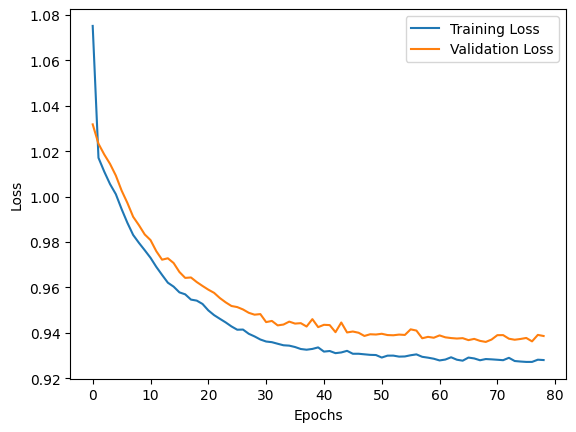

In [22]:
import matplotlib.pyplot as plt

plt.plot(vae.history.history['loss'], label="Training Loss")
plt.plot(vae.history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [27]:
from tensorflow.keras.models import Model

# Define a decoder model (from latent space to output sequence)
decoder_input = Input(shape=(LATENT_DIM,), name="decoder_input")
x = RepeatVector(TIME_STEPS)(decoder_input)
x = LSTM(32, return_sequences=True)(x)
x = LSTM(64, return_sequences=True)(x)
decoder_outputs = TimeDistributed(Dense(FEATURE_DIM), name="decoder_output")(x)

# Create the decoder model
decoder = Model(decoder_input, decoder_outputs, name="Decoder")


In [30]:
for layer in vae.layers:
    print(layer.name)


encoder_input
lstm_24
dropout_2
lstm_25
z_mean
z_log_var
z
repeat_vector_6
lstm_26
dropout_3
lstm_27
decoder_output
vae_loss_layer_2


In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, RepeatVector

# Extract the decoder part from the trained VAE
decoder_input = Input(shape=(LATENT_DIM,), name="decoder_input")
x = RepeatVector(TIME_STEPS)(decoder_input)  # Repeat for sequence generation
x = vae.get_layer("lstm_26")(x)  # First LSTM layer from VAE decoder
x = vae.get_layer("dropout_3")(x)  # Dropout layer (if applicable)
x = vae.get_layer("lstm_27")(x)  # Second LSTM layer from VAE decoder
decoder_outputs = vae.get_layer("decoder_output")(x)  # Final Dense layer

# Create the decoder model
decoder = Model(decoder_input, decoder_outputs, name="Trained_Decoder")


In [32]:
import numpy as np

# Generate a random latent vector
random_latent_vector = np.random.normal(size=(1, LATENT_DIM))

# Decode into a sequence
generated_sequence = decoder.predict(random_latent_vector)

print("Generated music feature sequence:", generated_sequence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
Generated music feature sequence: [[[8.55773866e-01 1.13708731e-02 2.16843747e-03 5.43127298e-01
   4.72619990e-03 7.61349559e-01 8.84498060e-02 8.36021304e-01
   3.19612324e-01 8.84410739e-01 3.32979947e-01 8.39641571e-01
   4.66194749e-01 8.26014638e-01 8.52994204e-01 7.99227118e-01
   8.66094470e-01 8.35565090e-01 8.36536765e-01 8.20589244e-01
   7.34665036e-01 8.10159087e-01 7.73386300e-01 8.51188540e-01
   8.48102450e-01 9.25119877e-01 9.73565280e-01 9.58378613e-01
   8.66612673e-01 7.32612014e-01 6.30586982e-01 5.53284705e-01
   4.54883426e-01 3.34897548e-01 2.99240589e-01 2.14388028e-01
   1.75195426e-01 1.40451595e-01 1.32249743e-01 1.28417060e-01
   1.11850142e-01 9.80717391e-02 9.26932469e-02 8.89247805e-02
   7.85538778e-02 5.07505313e-02 6.00322373e-02 6.69491217e-02
   6.98310807e-02 5.04373200e-02 7.06836730e-02 1.23532206e-01
   8.45862031e-02 8.46141577e-02 1.34579867e-01 1.24614045e-01
   1.26131073e-01 1.26304403e-01 8.81458521e-

In [34]:
import numpy as np
import pretty_midi

def generate_midi_from_features(features, output_file="generated_music.mid"):
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    time = 0  # Start time for notes
    for feature in features:
        pitch = int(np.clip(feature[0] * 127, 0, 127))  # Scale feature to MIDI pitch range
        duration = np.clip(feature[1], 0.1, 2.0)  # Ensure reasonable duration
        velocity = int(np.clip(feature[2] * 127, 10, 127))  # Scale feature to MIDI velocity
        
        note = pretty_midi.Note(
            velocity=velocity, pitch=pitch, start=time, end=time + duration
        )
        instrument.notes.append(note)
        time += duration  # Move time forward

    midi.instruments.append(instrument)
    midi.write(output_file)
    print(f"Saved MIDI file as {output_file}")

# Example: Using your generated features
features = np.random.rand(50, 3)  # Replace this with your actual feature array
generate_midi_from_features(features)


Saved MIDI file as generated_music.mid


In [35]:
!pip install fluidsynth


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fluidsynth: filename=fluidsynth-0.2-py3-none-any.whl size=4522 sha256=25742c1e47f317125050821463605a725080e4fb58db8ca701e78b68dd7392c2
  Stored in directory: c:\users\jayes\appdata\local\pip\cache\wheels\72\5a\bf\347b142f199fb1bea87f16f8970916226951bc359c947ba19b
Successfully built fluidsynth



[notice] A new release of pip is available: 24.1.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import subprocess

fluidsynth_path = r"D:\\Fluidsynth\\bin\\fluidsynth.exe"  # Change to your actual path

subprocess.run([fluidsynth_path, "-ni", 
                "D:\\music generation\\soundfont.sf2", 
                "D:\\music generation\\generated_music.mid", 
                "-F", "D:\\music generation\\output.wav", "-r", "44100"], 
                check=True)


CompletedProcess(args=['D:\\\\Fluidsynth\\\\bin\\\\fluidsynth.exe', '-ni', 'D:\\music generation\\soundfont.sf2', 'D:\\music generation\\generated_music.mid', '-F', 'D:\\music generation\\output.wav', '-r', '44100'], returncode=0)

In [1]:
import librosa
import numpy as np

# Sample audio file
audio_file = "D:\\music generation\\fma_small_extracted\\fma_small\\125\\125182.mp3"

# Define fixed feature sizes (same as training)
MFCC_SIZE = 13
CHROMA_SIZE = 12
MEL_SIZE = 40
SPEC_CONTRAST_SIZE = 7
TOTAL_FEATURES = MFCC_SIZE + CHROMA_SIZE + MEL_SIZE + SPEC_CONTRAST_SIZE + 6  # +6 (not +5, because tempo was missing)

def pad_or_truncate(feature, length):
    """Ensure a feature vector has the required fixed length."""
    if len(feature) > length:
        return feature[:length]  # Truncate
    return feature + [0] * (length - len(feature))  # Pad with zeros

def extract_sample_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=44100, mono=True, duration=25, res_type="kaiser_fast")

        # Skip empty or silent files
        if len(y) == 0 or np.mean(np.abs(y)) < 1e-10:
            print(f"Skipping {file_path}: Empty or silent audio")
            return None

        features = []

        features.extend(pad_or_truncate(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=MFCC_SIZE).mean(axis=1).tolist(), MFCC_SIZE))
        features.extend(pad_or_truncate(librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1).tolist(), CHROMA_SIZE))
        features.extend(pad_or_truncate(librosa.feature.melspectrogram(y=y, sr=sr).mean(axis=1).tolist(), MEL_SIZE))
        features.extend(pad_or_truncate(librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1).tolist(), SPEC_CONTRAST_SIZE))
        
        # Extra spectral features
        features.append(librosa.feature.spectral_centroid(y=y, sr=sr).mean())
        features.append(librosa.feature.spectral_bandwidth(y=y, sr=sr).mean())
        features.append(librosa.feature.spectral_rolloff(y=y, sr=sr).mean())
        features.append(librosa.feature.zero_crossing_rate(y).mean())
        features.append(librosa.feature.rms(y=y).mean())

        # Add Tempo (missing in your code)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features.append(tempo.item() if tempo.size > 0 else 0.0)  # Ensure tempo is always included

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extract features from sample audio
sample_features = extract_sample_features(audio_file)

if sample_features is not None:
    sample_features = np.array(sample_features).reshape(1, TOTAL_FEATURES)  # Reshape to (1, feature_dim)

    print("Extracted Sample Features Shape:", sample_features.shape)  # Should match training shape


Extracted Sample Features Shape: (1, 78)


In [2]:
from keras.models import load_model

# Load trained model
MODEL_PATH = "my_model.keras"  # Update with correct path
model = load_model(MODEL_PATH)

# Use extracted sample features (shape: (1, 78))
sample_features = np.array(sample_features).reshape(1, 78)  # Ensure it's (1, 78)

# **Fix Input Shape: Convert (1, 78) → (1, 10, 78)**
TIME_STEPS = 10
FEATURE_DIM = 78

# Option 1: **Repeat the features across 10 time steps**  
reshaped_features = np.tile(sample_features, (TIME_STEPS, 1)).reshape(1, TIME_STEPS, FEATURE_DIM)

# Predict music from extracted features
generated_output = model.predict(reshaped_features)

print("Generated Music Output Shape:", generated_output.shape)
print("Generated Data Sample:", generated_output[:5])  # Print a preview of the generated output

# TODO: Convert `generated_output` into MIDI/audio format for listening


TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 10, 78], 'dtype': 'float32', 'sparse': False, 'name': 'encoder_input'}, 'registered_name': None, 'name': 'encoder_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None, 'shared_object_id': 3087604169120}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None, 'shared_object_id': 3087604168880}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None, 'shared_object_id': 3087604169072}, 'unit_forget_bias': True, 'kernel_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 0.0001}, 'registered_name': None, 'shared_object_id': 3087458561104}, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 78]}, 'name': 'lstm_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 78], 'dtype': 'float32', 'keras_history': ['encoder_input', 0, 0]}}], 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 64]}, 'name': 'dropout_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 64], 'dtype': 'float32', 'keras_history': ['lstm_4', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 32, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None, 'shared_object_id': 3087604170464}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None, 'shared_object_id': 3087604170320}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None, 'shared_object_id': 3087604170032}, 'unit_forget_bias': True, 'kernel_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 0.0001}, 'registered_name': None, 'shared_object_id': 3087604165184}, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 64]}, 'name': 'lstm_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 64], 'dtype': 'float32', 'keras_history': ['dropout_2', 0, 0]}}], 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'z_mean', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32]}, 'name': 'z_mean', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32], 'dtype': 'float32', 'keras_history': ['lstm_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'z_log_var', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32]}, 'name': 'z_log_var', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32], 'dtype': 'float32', 'keras_history': ['lstm_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'z', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'sampling', 'registered_name': 'function'}, 'output_shape': [16], 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16], [None, 16]]}, 'name': 'z', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['z_mean', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['z_log_var', 0, 0]}}]], 'kwargs': {'mask': [None, None]}}]}, {'module': 'keras.layers', 'class_name': 'RepeatVector', 'config': {'name': 'repeat_vector_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'n': 10}, 'registered_name': None, 'build_config': {'input_shape': [None, 16]}, 'name': 'repeat_vector_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['z', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 32, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None, 'shared_object_id': 3087604387840}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None, 'shared_object_id': 3087604387936}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None, 'shared_object_id': 3087604392016}, 'unit_forget_bias': True, 'kernel_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 0.0001}, 'registered_name': None, 'shared_object_id': 3087603542496}, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 16]}, 'name': 'lstm_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 16], 'dtype': 'float32', 'keras_history': ['repeat_vector_1', 0, 0]}}], 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 32]}, 'name': 'dropout_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 32], 'dtype': 'float32', 'keras_history': ['lstm_6', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None, 'shared_object_id': 3087604397680}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None, 'shared_object_id': 3087604397776}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None, 'shared_object_id': 3087604397872}, 'unit_forget_bias': True, 'kernel_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 0.0001}, 'registered_name': None, 'shared_object_id': 3087604386448}, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 32]}, 'name': 'lstm_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 32], 'dtype': 'float32', 'keras_history': ['dropout_3', 0, 0]}}], 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'TimeDistributed', 'config': {'name': 'decoder_output', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'layer': {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'units': 78, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 64]}, 'name': 'decoder_output', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 64], 'dtype': 'float32', 'keras_history': ['lstm_7', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': None, 'class_name': 'VAELossLayer', 'config': {'name': 'vae_loss_layer_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}}, 'registered_name': 'Custom>VAELossLayer', 'build_config': {'input_shape': [[None, 10, 78], [None, 10, 78], [None, 16], [None, 16]]}, 'name': 'vae_loss_layer_1', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 78], 'dtype': 'float32', 'keras_history': ['encoder_input', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 10, 78], 'dtype': 'float32', 'keras_history': ['decoder_output', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['z_mean', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['z_log_var', 0, 0]}}]], 'kwargs': {}}]}], 'input_layers': [['encoder_input', 0, 0]], 'output_layers': [['vae_loss_layer_1', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'AdamW', 'config': {'name': 'adamw', 'learning_rate': 0.0010000000474974513, 'weight_decay': 0.0001, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': None, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class 'keras.src.layers.core.lambda_layer.Lambda'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'z', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 3087371109280}, 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'sampling', 'registered_name': 'function'}, 'output_shape': [16], 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16], [None, 16]]}, 'name': 'z', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['z_mean', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16], 'dtype': 'float32', 'keras_history': ['z_log_var', 0, 0]}}]], 'kwargs': {'mask': [None, None]}}]}.

Exception encountered: Could not locate function 'sampling'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'sampling', 'registered_name': 'function'}

In [ ]:
import numpy as np
import pretty_midi

# MIDI Program Numbers
INSTRUMENTS = {
    "melody": 56,  #violin
    "chords": 25,  # Acoustic Guitar (Steel)
    "bass": 32,  # Electric Bass (Finger)
    "drums": 0  # Drums (is_drum=True)
}

# Chord progression: I - V - vi - IV (C-G-Am-F)
CHORDS = {
    "C": [48, 52, 55],  # C major
    "G": [43, 47, 50],  # G major
    "Am": [45, 48, 52],  # A minor
    "F": [41, 45, 48],  # F major
}
CHORD_ORDER = ["G", "Am", "C", "F"]

# Convert AI output to MIDI notes
def output_to_midi_notes(generated_output, scale):
    return [scale[int(np.interp(note, (generated_output.min(), generated_output.max()), (0, len(scale) - 1)))] for note in generated_output.flatten()]

# Create structured MIDI with tempo-based timing
def create_structured_midi(notes, output_midi_path="structured_music.mid", tempo=300):
    midi = pretty_midi.PrettyMIDI()
    
    # Convert tempo to beat duration (seconds per beat)
    beat_length = 60.0 / tempo

    # Define instruments
    melody = pretty_midi.Instrument(program=INSTRUMENTS["melody"])  # **Flute**
    chords = pretty_midi.Instrument(program=INSTRUMENTS["chords"])  # **Guitar**
    bass = pretty_midi.Instrument(program=INSTRUMENTS["bass"])  # **Bass Guitar**
    drums = pretty_midi.Instrument(program=INSTRUMENTS["drums"], is_drum=True)  # **Drum Kit**

    start_time = 0.0

    for i, note in enumerate(notes):
        melody_velocity = np.random.randint(120, 127)  # **Make melody stronger**
        chord_velocity = np.random.randint(70, 90)  # **Chords medium volume**
        bass_velocity = np.random.randint(70, 80)  # **Bass slightly stronger**
        drum_velocity = np.random.randint(50, 70)  # **Lower drum volume**
        duration = beat_length * (1 + np.random.uniform(-0.1, 0.2))  

        if 60 <= note < 80:
            melody_note = pretty_midi.Note(velocity=melody_velocity, pitch=note, start=start_time, end=start_time + duration)
            melody.notes.append(melody_note)

        # **Chords (Guitar)**
        if i % 4 == 0:  # Change chords every 4 beats
            chord = CHORDS[CHORD_ORDER[(i // 4) % len(CHORD_ORDER)]]
            for chord_note in chord:
                chord_midi = pretty_midi.Note(velocity=chord_velocity, pitch=chord_note, start=start_time, end=start_time + beat_length * 6)  # **Make chords sustain longer**
                chords.notes.append(chord_midi)

        # **Bassline (Bass Guitar)**
        if note < 50:
            bass_note = pretty_midi.Note(velocity=bass_velocity, pitch=note, start=start_time, end=start_time + duration * 2)
            bass.notes.append(bass_note)

        # **Drums (Kick, Snare, Hi-hat)**
        if i % 4 == 0:
            kick = pretty_midi.Note(velocity=drum_velocity, pitch=36, start=start_time, end=start_time + 0.2)
            drums.notes.append(kick)
        if i % 4 == 2:
            snare = pretty_midi.Note(velocity=drum_velocity, pitch=38, start=start_time, end=start_time + 0.2)
            drums.notes.append(snare)
        if i % 2 == 1:
            hihat = pretty_midi.Note(velocity=drum_velocity - 10, pitch=42, start=start_time, end=start_time + 0.1)
            drums.notes.append(hihat)

        start_time += beat_length

    # Add instruments to MIDI
    midi.instruments.extend([melody, chords, bass, drums])
    midi.write(output_midi_path)
    print(f"MIDI file saved: {output_midi_path} with tempo {tempo} BPM")

# Use a musical scale (C Major)
C_MAJOR_SCALE = [48, 50, 52, 53, 55, 57, 59, 60, 62, 64, 65, 67, 69, 71, 72]

# Convert output to MIDI notes and save structured music
generated_notes = output_to_midi_notes(generated_output, C_MAJOR_SCALE)
create_structured_midi(generated_notes, tempo=270)  # Set desired tempo


NameError: name 'generated_output' is not defined

In [ ]:
import subprocess

fluidsynth_path = r"D:\\Fluidsynth\\bin\\fluidsynth.exe"  # Change to your actual path

subprocess.run([fluidsynth_path, "-ni", 
                "D:\\music generation\\soundfont.sf2", 
                "D:\\music generation\\structured_music.mid", 
                "-F", "D:\\music generation\\output.wav", "-r", "44100"], 
                check=True)


CompletedProcess(args=['D:\\\\Fluidsynth\\\\bin\\\\fluidsynth.exe', '-ni', 'D:\\music generation\\soundfont.sf2', 'D:\\music generation\\generated_music.mid', '-F', 'D:\\music generation\\output.wav', '-r', '44100'], returncode=0)

In [4]:
import pygame

pygame.init()
pygame.mixer.init()
pygame.mixer.music.load("structured_music.mid")
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    pygame.time.wait(1000)  # Wait for music to finish


pygame 2.6.0 (SDL 2.28.4, Python 3.10.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


KeyboardInterrupt: 